# Decision Bayesienne

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from matplotlib import pyplot as plt 
from sklearn.base import BaseEstimator, MetaEstimatorMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import expon
from scipy.integrate import dblquad


In [102]:
pi1 = 0.6
pi2 = 1 - pi1
lambda1 = 1
lambda2 = 2
theta1 = 2
theta2 = 1
n = 10000
n1 = np.random.binomial(n, pi1, 1)[0]
n2 = n - n1

In [103]:
X1 = np.column_stack(
    (
        np.random.exponential(scale=1/lambda1, size=n1),
        np.random.exponential(scale=1/lambda2, size=n1)
    )
)

In [104]:
X2 = np.column_stack(
    (
        np.random.exponential(scale=1/theta1, size=n2),
        np.random.exponential(scale=1/theta2, size=n2)
    )
)

In [105]:
X = np.concatenate((X1, X2), axis=0)
z = np.repeat([0, 1], [n1, n2])

In [106]:
X, z = shuffle(X, z)

In [107]:
df = pd.DataFrame(data=np.concatenate((X,z[:,None]), axis=1), columns=["X1", "X2", "z"])

In [108]:
df = df.assign(z=df.z.astype(int))

In [109]:
df

,X1,X2,z
0,0.051553,0.429290,0
1,0.090365,0.149828,0
2,0.550615,0.124764,0
3,0.012424,0.724413,0
4,1.084257,0.436229,0
...,...,...,...
9995,0.863801,0.918477,0
9996,0.821249,1.071377,0
9997,0.747810,0.143582,0
9998,0.794899,0.095213,0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f71578ebe50>, None)

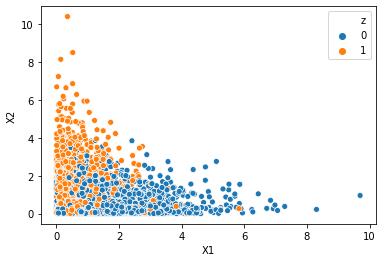

In [110]:
scatterplot_pca(data=df, columns=["X1", "X2"], hue=df.z)

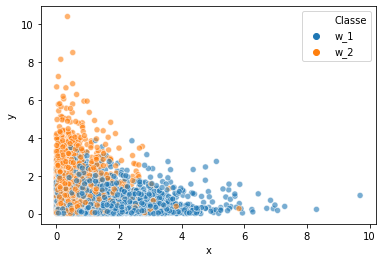

In [111]:
classes = np.array(["w_1", "w_2"])[z]
data = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], Classe=classes))
sns.scatterplot(x="x", y="y", hue="Classe", data=data, alpha=.6)
plt.show()

In [112]:
def delta(row):
    '''Implementation of decision function
        row if the rows of(x1, x2)
    '''
    x1, x2 = row
    cste = np.log(theta1*theta2*pi2/(lambda1*lambda2*pi1))
    d = (theta1 - lambda1) * x1 + (theta2 - lambda2) * x2 - cste
    return d

pred = np.apply_along_axis(delta, 1, X)
pred = (pred < 0).astype(int)
taux_Bayes = np.mean(pred != z)
taux_Bayes


0.3092

In [113]:
def predict(X):
    return np.apply_along_axis(delta, 1, X)

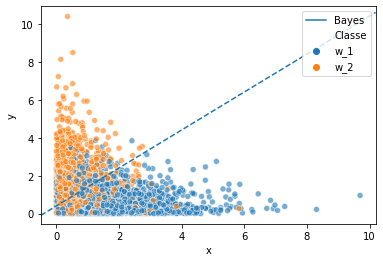

In [114]:
sns.scatterplot(x="x", y="y", hue="Classe", data=data, alpha=.6)
add_decision_boundary(predict, levels=[0], label="Bayes")
plt.show()

## compare to kmeans

In [115]:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.33)
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, z_train)
search.best_params_

{'n_neighbors': 500}

In [116]:
z_pred = search.predict(X_test)
miscls_KNN = 1 - accuracy_score(z_pred, z_test)
miscls_KNN

0.30272727272727273

In [117]:
z_pred = search.predict(X_train)
miscls_KNN_train = 1 - accuracy_score(z_train, z_pred)
miscls_KNN_train

0.3123880597014925

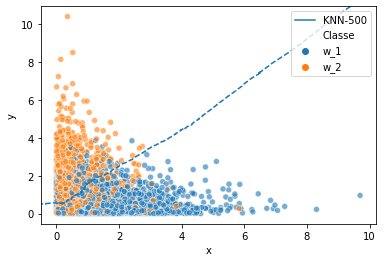

In [119]:
sns.scatterplot(x="x", y="y", hue="Classe", data=data, alpha=.6)
add_decision_boundary(search, label=f"KNN-{search.best_params_['n_neighbors']}")
plt.show()


In [125]:
def err_function(x, y):
    f1x = expon(scale=1/lambda1).pdf(x)
    f1y = expon(scale=1/lambda2).pdf(y)
    f2x = expon(scale=1/theta1).pdf(x)
    f2y = expon(scale=1/theta2).pdf(y)
    return min(pi1 * f1x * f1y, pi2 * f2x * f2y)


In [126]:
dblquad(err_function, 0, np.inf, 0, np.inf, epsabs=1e-3)

(0.31110590440142405, 0.0009941577509708348)

In [21]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """
    Utilise `sns.scatterplot` en appliquant d'abord une ACP si besoin
    pour réduire la dimension.
    """

    # Select columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    sp_kwargs = {}
    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        sp_kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        sp_kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **sp_kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.
    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca


def add_decision_boundary(model, levels=None, resolution=1000, ax=None, label=None):
    """Trace une frontière de décision sur une figure existante.

    La fonction utilise `model` pour prédire un score ou une classe
    sur une grille de taille `resolution`x`resolution`. Une (ou
    plusieurs frontières) sont ensuite tracées d'après le paramètre
    `levels` qui fixe la valeur des lignes de niveaux recherchées.

    """

    if ax is None:
        ax = plt.gca()


    if isinstance(model, MetaEstimatorMixin):
        return add_decision_boundary(model.best_estimator_, levels=levels, resolution=resolution, ax=ax, label=label)

    elif callable(model):
        if levels is None:
            levels = [0]
        def predict(X):
            return model(X)

    elif isinstance(model, BaseEstimator):
        n_classes = len(model.classes_)
        if "decision_function" in dir(model):
            if n_classes == 2:
                if levels is None:
                    levels = [0]
                def predict(X):
                    return model.decision_function(X)
        else:
            levels = np.arange(n_classes - 1) + .5
            def predict(X):
                pred = model.predict(X)
                _, idxs = np.unique(pred, return_inverse=True)
                return idxs
    else:
        raise Exception("Modèle pas supporté")


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = predict(xy).reshape(XX.shape)

    scout, = ax.plot([], [], linestyle="dashed")
    orig_color = scout.get_color()
    sns.lineplot([0], [0], label=label, ax=ax, color=orig_color, linestyle="dashed")

    ax.contour(
        XX,
        YY,
        Z,
        levels=levels,
        colors=orig_color,
        linestyles="dashed",
        antialiased=True,
    )
